In this notedbook I

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cv2
import pickle
import collections
import seaborn as sns
import glob
from matplotlib.pyplot import *
from utility import *
from os.path import basename, splitext
import dask
from dask import bag, compute, delayed
from dask.distributed import Client

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
client = Client(scheduler_file='/home/bzr0014/schedfile')
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


**1/s is the resolution of a single pixel. That is, a single pixel in the microscopy images map to 
 $0.42910444 \times 0.42915508 \mu m^2$**

In [4]:
s = np.array([2.330435, 2.33016])

In [5]:
#from collections import namedtuple
#Params = namedtuple('Params', "name, variation, fun")
#Arg = namedtuple('Arg', "meta, value")

In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, plot_title="", cbarlabel="", color_bar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = None
    if color_bar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(plot_title)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
columns = ['profile'] + list(Circle._fields)
functions = set()
circle_functions = set()
def feature(fun):
    functions.add(fun.__name__)
    return fun

def circle_feature(fun):
    circle_functions.add(fun.__name__)
    return fun

def log(s):
    print("[*] %s"%s)
    
def p(n):
    def pp(x):
        return np.percentile(x, n)
    return pp

profile, beg, end, index, h, cx, cy, r =  'profile beg end index h cx cy r'.split()
#stats = df[[profile, r]].groupby(profile).aggregate(['mean', 'median', 'std', p(5)])
#smalles_5percent = df.apply(lambda x: x.r < stats.r.pp.loc[x.profile], axis=1)

class Features:
    circle_statistics = None
    statistics = None
    circles = None
    exceptions = []
    def __init__(self, x, edge_to_ignore=0):
        log('Starting...')
        if edge_to_ignore > 0:
            x = x[edge_to_ignore:-edge_to_ignore, edge_to_ignore:-edge_to_ignore]
        self.x = np.ma.array(x, mask=x<x.mean(axis=1, keepdims=True)-3.5*x.std(axis=1, keepdims=True))
        #self.x = np.array()#, mask=x<x.mean(axis=1, keepdims=True)-3.5*x.std(axis=1, keepdims=True))
        #y = self.x[self.x>self.x.mean(axis=1, keepdims=True)-3.5*self.x.std(axis=1, keepdims=True)]
        #self.kernel_sizes = [int(np.percentile(get_cut_points(profile, profile.mean()), 25)) for profile in self.x]
        self.kernel_sizes = [int(np.percentile(get_cut_points(profile, np.ma.median(profile)), 25)) 
                             for profile in self.x]
        log('Kernel sizes extracted')
        self.local_minima = [get_local_minima_2d(profile, kernel_size, mn=-1) 
                             for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local minima extracted')
        self.local_maxima = [get_local_minima_2d(-profile, kernel_size) 
                             for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local maxima extracted')
 
    @feature
    def ra(self):
        return np.mean(np.abs(self.x-np.mean(self.x, axis=1, keepdims=True)), axis=1)

    @feature
    def rq(self):
        return np.sqrt(np.mean((self.x-np.mean(self.x, axis=1, keepdims=True))**2, axis=1))


    @feature
    def rv(self):
        return np.max(self.x-np.mean(self.x, axis=1, keepdims=True), axis=1)

    @feature
    def rz(self):
        return -np.min(self.x - np.mean(self.x, axis=1, keepdims=True), axis=1)

    @feature
    def r10_iso(self):
        return np.array([np.mean(np.sort(self.x[n][self.local_maxima[n]])[:10] ) for n in range(len(self.x))]) - \
            np.array([np.mean(np.sort(self.x[n][self.local_minima[n]])[-10:]) for n in range(len(self.x))])
    
    def get_all_circles(self):
        allCircles = []
        for i, profile in enumerate(self.x):
            try:
                x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                                     profile,
                                                                     kernel_size_param=self.kernel_sizes[i],
                                                                     same_scale=True, verbose=False)       
                if i%500==0:
                    log("Finished extracting circles from profile %5d/%5d"%(i, len(self.x)))
                allCircles.append(circles)
            except Exception as e:
                self.exceptions.append(["Exception occurred for profile %d"])
        self.circles = pd.DataFrame(((i, *circle) for i, circles in enumerate(allCircles) for circle in circles), columns=columns)   
        return self
    
    @circle_feature
    def rho(self):
        if self.circles is None:
            self.get_all_circles()
        return self.circles[['profile', 'r']].groupby('profile').aggregate('mean')
    
    @circle_feature
    def rho95(self):
        if self.circles is None:
            self.get_all_circles()       
        mardas = self.circles[['profile', 'r']].groupby('profile').aggregate(p(5))
        return self.circles[self.circles.apply(lambda x: x.r < mardas.r.loc[x.profile], axis=1)][['profile', 'r']].groupby('profile').aggregate('mean')
       
    def run_all_tests(self):
        log('Starting to run all tests.')
        self.run_all_rhos()
        return self.run_all_non_rhos()
    
    def run_all_non_rhos(self):
        log('Starting to get global properties')
        if self.statistics is None:
            self.statistics = pd.DataFrame({name: getattr(self, name)() for name in functions})
        return self
    
    def run_all_rhos(self):
        log('Starting to get global properties')
        if self.circle_statistics is None:
            circle_statistics = {name: getattr(self, name)() for name in circle_functions}
            self.circle_statistics = pd.concat((x for x in circle_statistics.values()), axis=1)
            self.circle_statistics.columns = circle_statistics.keys()
    #self.circle_statistics = {name: getattr(self, name)() for name in circle_functions}
        return self
        

#GlobalFeatures = collections.namedtuple('GlobalFeatures', functions)

In [8]:
def separate_outliers(x, t=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    m = np.median(x)
    iqr = q3-q1
    outliers = (x < q1-t*iqr) | (x>q3+t*iqr)
    return x[~outliers], x[outliers]

In [9]:
#def get_global_stats(df):
#    #average neighborhood size
#    x, xp = separate_outliers(df.end-df.beg)
#    x, xp = separate_outliers(x)
#    boxplot(x)
def q1(x):
    return np.percentile(x, 25)
def q3(x):
    return np.percentile(x, 75)
def p95(x):
    return np.percentile(x, 95)
def p5(x):
    return np.percentile(x, 5)

In [10]:
import scipy.stats as st
def gkern2d(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.max()
def gkern1d(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    return kern1d/kern1d.max()

In [11]:
def p(n):
    def pp(x):
        return np.percentile(x, n)
    return pp

In [12]:
def get_all_circles(rotated):
    allCircles = []
    for i, profile in enumerate(rotated):
        _kernel_size = int(np.percentile(get_cut_points(profile, profile.mean()), 25))
        #print("kernel size param %r"%_kernel_size)
        x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                             profile,
                                                             kernel_size_param=_kernel_size,
                                                             same_scale=True, verbose=False)       
        if i%300==0:
            draw_circles(x, y, circles)
            show()
        allCircles.append(circles)
    return allCircles

In [13]:
data_root = "/nfs_shares/bzr0014_home/additive_data/"

In [14]:
#ls $data_root/experiment_03

In [15]:
import joblib
#df = joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_03/Polished_V09_T2_Right(Top)_500X_3D.info')

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

def get_derivatives(y):
    dy = y[1:]-y[:-1]
    ddy = dy[1:]-dy[:-1]
    dddy = ddy[1:]-ddy[:-1]
    return y[2:], dy[1:], ddy

def mardas(y, dy, ddy):
    main_cond = (y > (y.mean()-y.std()*6))
    dy_std = np.abs(dy).std()
    ddy_std = ddy.std()
    neg_d2 = np.where((ddy < 0) & main_cond)#& (y[2:] < y.mean()))
    minima = np.where((np.abs(dy)<dy_std/5) & (ddy > .001) & (y < y.mean()) & main_cond)[0]
    return minima, neg_d2
def raghas(y, minima, neg_d2):
    distance = ((neg_d2[0] - minima.reshape(-1, 1)))
    r_dist = np.min(np.where(distance<0, np.ones_like(distance)*1000, distance), axis=1)
    l_dist = np.max(np.where(distance>0, -np.ones_like(distance)*1000, distance), axis=1)
    return l_dist, r_dist

def zapas(y, dy, minima, l_dist, r_dist):
    t1 = defaultdict(list)
    for x, (l, r) in zip(minima, zip(minima + l_dist, minima + r_dist)):
        if r - l > len(y)/10: continue
        t1[(l, r)].append(x)
    t = {k: int(np.mean(v)) for k, v in t1.items()}
    t = {v: (y[k[0]:k[1]], dy[k[0]:k[1]], k[0]) for k, v in t.items()}
    return t


def alnas(y):
    y, dy, ddy = get_derivatives(y)
    minima, neg_d2 = mardas(y, dy, ddy)
    l_dist, r_dist = raghas(y, minima, neg_d2)
    t = zapas(y, dy, minima, l_dist, r_dist)
    return t
#Y = np.array(df['value'].x)
#n = np.random.randint(len(Y))
##n = 4208
##n = 215
#print(n)
#y = Y[n]
#t = alnas(y)
#fig, ax = plt.subplots(1, 1)
#
##plt.plot(np.arange(len(y)), np.abs(dy))
#plt.plot(np.arange(len(y)), y-y.mean())
#plt.plot([0, 7000], [0, 0])
#for x, (_y, _dy, l) in t.items():
#    plt.plot(np.arange(l, l+len(_y)), _y-y.mean(), c='red')
#lim = [1000, 1100]
#plt.xlim(lim)
#n = np.random.randint(len(_x))
#print(f"n={n}")
#rngs = (minima[n]+l_dist[n], maxima[n]+_right[n])
#l_rng = (_x[n]+_left[n], _x[n])
#r_rng = (_x[n], _x[n]+_right[n])
#
#x_s, x_ls, x_rs = np.arange(*rng), np.arange(*l_rng), np.arange(*r_rng)
#y_s, dy_s, ddy_s = y[slice(*rng)], dy[slice(*rng)], ddy[slice(*rng)]
#ax.plot(x_s, y_s)
#cx, cy, cr = Fit_circle(x_s, y_s).fit_circle()
#def get_range(x):
#    return np.max(x) - np.min(x)
#print(f"{_x[n]}, {cx}, {cr}, ")
#print(f"left_neigh = {-_left[n]}, right_neigh = {_right[n]} ")
#print(f"left_range = {get_range(y_s[:-_left[n]])}, right_range = {get_range(y_s[-_left[n]:])}")
#print(f"left_slope = {np.mean(-dy_s[:-_left[n]])}, right_slope = {np.mean(dy_s[-_left[n]:])}")

In [17]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [18]:
import joblib
files = bag.from_sequence(glob.glob(f"{data_root}/experiment_03/*info"))
res = {}
for file in files:
    df = joblib.load(file)
    print(f"loaded {file}")
    Y = bag.from_sequence(list(np.array(df['value'].x)))
    res[file] = Y.map(alnas).compute()
    print(f"finished {file}")
    print('************************************')

loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T1_Left(Bottom)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T1_Left(Bottom)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T1_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T1_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T2_Left(Bottom)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T2_Left(Bottom)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T2_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V01_T2_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_h

loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V17_T2_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V17_T2_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T1_L_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T1_L_3d.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T1_R_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T1_R_3d.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T2_L_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T2_L_3d.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T2_R_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v01_T2_R_3d.info
****************

finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V06_T1_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v06_T1_R_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v06_T1_R_3d.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V06_T2_Left(Bottom)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V06_T2_Left(Bottom)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/v06_T2_L_3d.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/v06_T2_L_3d.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V06_T2_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V06_T2_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_ho

finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T1_Left(Bottom)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T1_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T1_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T2_Left(Bottom)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T2_Left(Bottom)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T2_Right(Top)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T2_Right(Top)_500X_3D.info
************************************
loaded /nfs_shares/bzr0014_home/additive_data//experiment_03/V17_T1_Left(Bottom)_500X_3D.info
finished /nfs_shares/bzr0014_home/additive_data//experiment_03/V17_T1_Left(Bottom)_500X_3D.info
****

In [43]:
from os import path
for k, v in res.items():
    _ = path.splitext(path.basename(k))[0]
    joblib.dump(v, f"{data_root}/experiment_04/{_}.pkl")
    print(_)

Polished_V01_T1_Left(Bottom)_500X_3D
Polished_V01_T1_Right(Top)_500X_3D
Polished_V01_T2_Left(Bottom)_500X_3D
Polished_V01_T2_Right(Top)_500X_3D
Polished_V03_T1_Left(Bottom)_500X_3D
Polished_V03_T1_Right(Top)_500X_3D
Polished_V03_T2_Left(Bottom)_500X_3D
Polished_V03_T2_Right(Top)_500X_3D
Polished_V05_T1_Left(Bottom)_500X_3D
Polished_V05_T1_Right(Top)_500X_3D
Polished_V05_T2_Left(Bottom)_500X_3D
Polished_V05_T2_Right(Top)_500X_3D
Polished_V07_T1_Left(Bottom)_500X_3D
Polished_V07_T1_Right(Top)_500X_3D
Polished_V07_T2_Left(Bottom)_500X_3D
Polished_V07_T2_Right(Top)_500X_3D
Polished_V09_T1_Left(Bottom)_500X_3D
Polished_V09_T1_Right(Top)_500X_3D
Polished_V09_T2_Left(Bottom)_500X_3D
Polished_V09_T2_Right(Top)_500X_3D
Polished_V11_T1_Left(Bottom)_500X_3D
Polished_V11_T1_Right(Top)_500X_3D
Polished_V11_T2_Left(Bottom)_500X_3D
Polished_V11_T2_Right(Top)_500X_3D
Polished_V13_T1_Left(Bottom)_500X_3D
Polished_V13_T1_Right(Top)_500X_3D
Polished_V13_T2_Left(Bottom)_500X_3D
Polished_V13_T2_Right(Top)_

In [2]:
def topol(x):
    return np.mean(x), np.std(x), np.mean(np.abs(x)), np.std(np.abs(x))
def abpash(args):
    pn, prof, i, y, dy, l = args
    if len(y) < 3: return
    r = l+len(y)-i
    lr = (min(i-l, l+len(y)-i))
    if 2 * lr < 3: return
    return [pn, l, i, i+len(y), 
            *topol(y),
            *topol(y[:i-l]),
            *topol(y[i-l:]),
            *topol(dy),
            *topol(dy[:i-l]),
            *topol(dy[i-l:]),
            *Fit_circle(np.arange(i-lr, i+lr), y[i-l-lr:i-l+lr]).fit_circle(),
            *Fit_circle(np.arange(l, l+len(y)), y).fit_circle()
           ]

In [3]:
[len(x) for prof in res.values() l = [(pn, prof, i, y, dy, l) for pn, prof in enumerate(x) for i, (y, dy, l) in prof.items()

]

SyntaxError: invalid syntax (<ipython-input-3-16f02cfc6d62>, line 1)

125

In [ ]:
_ = np.array([k for k in t])
_[(_<lim[1])&(_>lim[0])]
np.abs(dy).mean()
t1

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

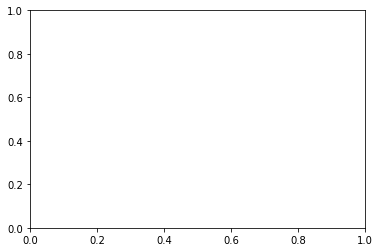

In [341]:
fig, ax = plt.subplots(1, 1)
_ = plt.Circle((cx, cy), r, alpha=.2)
ax.set_xlim(cx-r*3, cx+r*3)
ax.set_ylim(cy-r*3, cy+r*3)
ax.add_artist(_)
ax.plot(x, y)

In [12]:
def random_sub_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(ratio*w), int(ratio*h)
    x, y = np.random.randint(max(1,w-ww)), np.random.randint(max(1,h-hh))
    return img[x:x+ww, y:y+hh]

def random_sub_length_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w), int(ratio*h)
    x, y = 0, np.random.randint(max(1,h-hh))
    #print(x, y)
    return img[:, y:y+hh]

def random_sub_width_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w*h), int(ratio)
    x, y = np.random.randint(max(1,w-ww)), 0
    return img[x:x+ww, :]

def random_sub_profile_image(img, ratio=.5):
    return img[np.random.rand(len(img))<ratio]

In [13]:
images_mapper = {
          'Normal': lambda x:x, 
#          'Smoothed': lambda x: cv2.pyrUp(cv2.pyrDown((x))),
#          '50% area rotate': lambda x: align_image(random_sub_image(x)),
#          '50% area tilt': lambda x: adjust_tilt(random_sub_image(x)),
#          '50% area': lambda x: random_sub_image(x, .5),
#          '25% area': lambda x: random_sub_image(x, .25),
#    
#          '50% length': lambda x: random_sub_length_image(x, .5),
#          '25% length': lambda x: random_sub_length_image(x, .25),
#          '50% length rotate': lambda x: align_image(random_sub_length_image(x)),
#          '50% length tilt': lambda x: adjust_tilt(random_sub_length_image(x)),
#          '50% width': lambda x: random_sub_width_image(x),
#          '25% width': lambda x: random_sub_width_image(x, .25),
#          '50% width tilt': lambda x: adjust_tilt(random_sub_width_image(x)),
#          '50% random': lambda x: random_sub_profile_image(x, .50),
#          '25% random': lambda x: random_sub_profile_image(x, .25),
#          'Rotated': lambda x: align_image(x),
#          'Tilted': lambda x: adjust_tilt(x),
#          'Tilted & Rotated': lambda x: adjust_tilt(align_image(x))
                }

In [14]:
data_root = "/nfs_shares/bzr0014_home/additive_data/"
#image_info_ = {f"{data_root}{x}.pd":v for x, v in image_info.items()}

In [15]:
prcssd_fls = {dfe(x)[1] for x in glob.glob(f"{data_root}/experiment_03/*info")}

In [16]:
files = file_names = {x for x in glob.glob(f'{data_root}/*pd') if dfe(x)[1] not in prcssd_fls}
len(files)
#files = file_names = [x for x in glob.glob(f'{data_root}/*pd') if 'v01' in x.lower() or 'v07' in x.lower()]
#with ThreadingPool(2) as t:
#    stats_list = t.map(get_all_stats, file_names)
#stats_list = get_all_stats(file_names[0])

50

In [17]:
#new_image_info ={data: ImageInfo(max_height=7500, max_width=7500, max_peak=170) for data in files}

In [18]:
#new_image_info.update(image_info_)

In [19]:
file_names = [Params(name, variation, fun) for name in files for variation, fun in images_mapper.items()]
b_file_names = bag.from_sequence(file_names)

In [20]:
#file_names.compute()

In [21]:
from scipy.ndimage.filters import convolve
from scipy.ndimage import zoom
# #param
M = 31
_ = gkern2d(M, 5)
k3 = _ / _.sum()

In [37]:
import joblib
def _(x):
    print(x)
    return x
original_images = b_file_names.map(_).map(lambda x: joblib.load(x[0]))
def _(x):
    print(x.shape)
    return x
resized_images   = original_images.map(_).map(zoom, zoom=1/s)
smoothed_images = resized_images.map(_).map(convolve, weights=k3)

In [38]:
#c = a.map(lambda x: Arg(x.meta, (x.meta.fun(x[1]))))#.map(lambda x: Arg(x.meta, x.value.run_all_tests()))
#_ = c.take(2, npartitions=2)

In [39]:
c = smoothed_images.map(Features).map(lambda x: x.run_all_tests())
#c = a.map(lambda x: Arg(x.meta, Features(x.meta.fun(x[1]))))#.map(lambda x: Arg(x.meta, x.value.run_all_tests()))
#c = a.map(lambda x: Arg(x.meta, Features(x.meta.fun(x[1]))))#.map(lambda x: Arg(x.meta, x.value.run_all_tests()))

In [40]:
#c = a.map(lambda x: Arg(x.meta, Features(x.meta.fun(x[1])))).map(lambda x: Arg(x.meta, x.value.get_all_circles()))

In [ ]:
from multiprocessing import Pool
with dask.config.set(pool=Pool(50)):
    all_stats = c.compute()

Params(name='/nfs_shares/bzr0014_home/additive_data/V15_T1_Right(Top)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/V19_T1_Left(Bottom)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/V14_T2_Left(Bottom)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/Polished_V05_T2_Left(Bottom)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/Polished_V03_T1_Left(Bottom)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/Polished_V11_T2_Right(Top)_500X_3D.pd', variation='Normal', fun=<function <lambda> at 0x789754ed7f28>)
Params(name='/nfs_shares/bzr0014_home/additive_data/V15_T1_Left(Bottom)_500X_3D.pd', vari

(16895, 17968)
(15988, 17993)
(16921, 17997)
(16927, 17980)
(16899, 17969)
(16898, 17969)
(16900, 17954)
(15945, 17963)
(16914, 17955)
(16896, 17976)
(16923, 17969)
(16891, 17956)
(16921, 17996)
(7250, 7713)
(6858, 7720)
(6840, 7705)
(6844, 7702)
(6658, 7713)
(6657, 7720)
(7258, 7705)
(6658, 7711)
(7263, 7724)
(7263, 7724)
(7263, 7716)
(7251, 7711)
(7261, 7715)
(6857, 7714)
(6656, 7721)
(6656, 7717)
(7253, 7713)
(6658, 7715)
(6659, 7713)
(6859, 7714)
(7250, 7714)
(6857, 7722)
(6658, 7713)
(6861, 7722)
(6658, 7721)
(7252, 7705)
(7251, 7705)
(6857, 7724)
(6842, 7708)
(7248, 7706)
(6858, 7715)
(6841, 7702)
(7250, 7711)
(6841, 7703)
(7261, 7724)
(6858, 7716)
(6842, 7709)
(7252, 7705)
(7248, 7712)
(7252, 7704)
(7249, 7712)
(7261, 7723)
[*] Starting...
(7251, 7711)
(7260, 7716)
(7251, 7705)
(7262, 7711)
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...
[*] Starting...

[*] Local minima extracted
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Kernel sizes extracted
[*] Finished extracting circles from profile     0/ 7252
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Finished extracting circles from profile     0/ 6858
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Local minima extracted
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Finished extracting circles from profile     0/ 7261
[*] Finished extracting circles from profile     0/ 6842
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Finished extracting circles from profile     0/ 7248
[*] Local minima extracted
[*] Local maxima extracted
[*] Starting to run all tests.
[*] Starting to get global properties
[*] Finished extracting circles

[*] Finished extracting circles from profile  1000/ 7263
[*] Finished extracting circles from profile  1000/ 7261
[*] Finished extracting circles from profile  1000/ 7248
[*] Finished extracting circles from profile  1000/ 7261
[*] Finished extracting circles from profile  1000/ 6658
[*] Finished extracting circles from profile  1000/ 7263
[*] Finished extracting circles from profile  1000/ 7252
[*] Finished extracting circles from profile  1000/ 7251
[*] Finished extracting circles from profile  1000/ 7248
[*] Finished extracting circles from profile  1000/ 7261
[*] Finished extracting circles from profile  1000/ 6842
[*] Finished extracting circles from profile  1000/ 7262
[*] Finished extracting circles from profile  1000/ 6857
[*] Finished extracting circles from profile  1000/ 6842
[*] Finished extracting circles from profile  1000/ 6840
[*] Finished extracting circles from profile  1000/ 6656
[*] Finished extracting circles from profile  1000/ 7249
[*] Finished extracting circles

[*] Finished extracting circles from profile  2500/ 7252
[*] Finished extracting circles from profile  2500/ 7250
[*] Finished extracting circles from profile  2500/ 7251
[*] Finished extracting circles from profile  2500/ 7248
[*] Finished extracting circles from profile  2500/ 7261
[*] Finished extracting circles from profile  2500/ 7252
[*] Finished extracting circles from profile  2000/ 6858
[*] Finished extracting circles from profile  2500/ 7263
[*] Finished extracting circles from profile  2500/ 7252
[*] Finished extracting circles from profile  2500/ 6859
[*] Finished extracting circles from profile  2500/ 6656
[*] Finished extracting circles from profile  2500/ 6857
[*] Finished extracting circles from profile  2500/ 7251
[*] Finished extracting circles from profile  2500/ 7261
[*] Finished extracting circles from profile  2500/ 7263
[*] Finished extracting circles from profile  2500/ 6840
[*] Finished extracting circles from profile  2500/ 7248
[*] Finished extracting circles

[*] Finished extracting circles from profile  4000/ 7250
[*] Finished extracting circles from profile  4000/ 7252
[*] Finished extracting circles from profile  4000/ 7253
[*] Finished extracting circles from profile  4000/ 7251
[*] Finished extracting circles from profile  4000/ 7261
[*] Finished extracting circles from profile  4000/ 7248
[*] Finished extracting circles from profile  4000/ 6656
[*] Finished extracting circles from profile  4000/ 7252
[*] Finished extracting circles from profile  4000/ 7252
[*] Finished extracting circles from profile  4000/ 6658
[*] Finished extracting circles from profile  4000/ 7250
[*] Finished extracting circles from profile  4000/ 7263
[*] Finished extracting circles from profile  4000/ 6840
[*] Finished extracting circles from profile  3500/ 6842
[*] Finished extracting circles from profile  4500/ 6659
[*] Finished extracting circles from profile  4000/ 7263
[*] Finished extracting circles from profile  4000/ 6658
[*] Finished extracting circles

[*] Finished extracting circles from profile  5500/ 7258
[*] Finished extracting circles from profile  5500/ 7252
[*] Finished extracting circles from profile  5500/ 7250
[*] Finished extracting circles from profile  5500/ 7253
[*] Finished extracting circles from profile  6000/ 6659
[*] Finished extracting circles from profile  5000/ 7262
[*] Finished extracting circles from profile  5500/ 7251
[*] Finished extracting circles from profile  5500/ 7248
[*] Finished extracting circles from profile  5500/ 6840
[*] Finished extracting circles from profile  4500/ 6858
[*] Finished extracting circles from profile  5500/ 7252
[*] Finished extracting circles from profile  5500/ 7252
[*] Finished extracting circles from profile  6000/ 6658
[*] Finished extracting circles from profile  5500/ 6857
[*] Finished extracting circles from profile  5000/ 7249
[*] Finished extracting circles from profile  5500/ 6658
[*] Finished extracting circles from profile  5500/ 7261
[*] Finished extracting circles

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  5000/ 6858
[*] Finished extracting circles from profile  6000/ 6857
[*] Finished extracting circles from profile  6500/ 6656
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 7263


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6000/ 7250
[*] Finished extracting circles from profile  6000/ 6656
[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 6861
[*] Finished extracting circles from profile  5500/ 7251


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 6841
[*] Finished extracting circles from profile  6500/ 6857
[*] Finished extracting circles from profile  6500/ 6658
[*] Finished extracting circles from profile  6500/ 6841


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


[*] Finished extracting circles from profile  6500/ 6658
[*] Finished extracting circles from profile  6500/ 6657
[*] Finished extracting circles from profile  6000/ 7251
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 6859
[*] Finished extracting circles from profile  6000/ 7261


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 7263
[*] Finished extracting circles from profile  6500/ 7251
[*] Finished extracting circles from profile  6000/ 7248
[*] Finished extracting circles from profile  6500/ 7250
[*] Finished extracting circles from profile  6500/ 6842
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 7260
[*] Finished extracting circles from profile  6500/ 6844
[*] Finished extracting circles from profile  5500/ 6842
[*] Starting to get global properties


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 7261


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 6858
[*] Finished extracting circles from profile  6500/ 7258
[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 7252


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6000/ 6842
[*] Finished extracting circles from profile  6500/ 7250
[*] Finished extracting circles from profile  5500/ 6858
[*] Finished extracting circles from profile  6500/ 7253
[*] Finished extracting circles from profile  6500/ 7248
[*] Finished extracting circles from profile  6500/ 6840
[*] Finished extracting circles from profile  6500/ 7251
[*] Finished extracting circles from profile  6000/ 7262
[*] Finished extracting circles from profile  6500/ 7252
[*] Finished extracting circles from profile  6500/ 6658
[*] Finished extracting circles from profile  6500/ 7252
[*] Finished extracting circles from profile  6500/ 7261
[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 6658
[*] Finished extracting circles from profile  6500/ 6857


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 6658
[*] Starting to get global properties
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 7249


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 7263
[*] Finished extracting circles from profile  5500/ 6858
[*] Finished extracting circles from profile  6500/ 7263
[*] Finished extracting circles from profile  6500/ 6857
[*] Finished extracting circles from profile  6500/ 6656
[*] Finished extracting circles from profile  6500/ 7250
[*] Finished extracting circles from profile  6000/ 7251
[*] Starting to get global properties


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 6859


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Starting to get global properties


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 7251
[*] Finished extracting circles from profile  7000/ 7251
[*] Finished extracting circles from profile  6500/ 7261
[*] Starting to get global properties
[*] Finished extracting circles from profile  7000/ 7263


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Finished extracting circles from profile  7000/ 7250


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Finished extracting circles from profile  6500/ 7248
[*] Finished extracting circles from profile  7000/ 7258
[*] Finished extracting circles from profile  6000/ 6842
[*] Finished extracting circles from profile  6500/ 6842
[*] Finished extracting circles from profile  6500/ 7261
[*] Finished extracting circles from profile  7000/ 7252
[*] Finished extracting circles from profile  7000/ 7250
[*] Finished extracting circles from profile  7000/ 7251
[*] Finished extracting circles from profile  6500/ 7260
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 6858


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  6500/ 7262
[*] Finished extracting circles from profile  7000/ 7253
[*] Starting to get global properties


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Starting to get global properties
[*] Finished extracting circles from profile  7000/ 7252
[*] Finished extracting circles from profile  7000/ 7248
[*] Finished extracting circles from profile  7000/ 7252
[*] Finished extracting circles from profile  7000/ 7261
[*] Starting to get global properties
[*] Finished extracting circles from profile  7000/ 7263
[*] Finished extracting circles from profile  6500/ 7249
[*] Starting to get global properties
[*] Finished extracting circles from profile  7000/ 7263
[*] Starting to get global properties
[*] Finished extracting circles from profile  6000/ 6858


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.


[*] Finished extracting circles from profile  7000/ 7250


/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Warning: converting a masked element to nan.
Process ForkPoolWorker-174:
Process ForkPoolWorker-197:
Process ForkPoolWorker-155:
Process ForkPoolWorker-176:
Process ForkPoolWorker-194:
Process ForkPoolWorker-187:
Process ForkPoolWorker-196:
Process ForkPoolWorker-184:
Process ForkPoolWorker-198:
Process ForkPoolWorker-180:
Process ForkPoolWorker-178:
Process ForkPoolWorker-165:
Process ForkPoolWorker-183:
Process ForkPoolWorker-188:
Process ForkPoolWorker-152:
Process ForkPoolWorker-190:
Process ForkPoolWorker-175:
Process ForkPoolWorker-195:
Process ForkPoolWorker-186:
Process ForkPoolWorker-191:
Process ForkPoolWorker-157:
Process ForkPoolWorker-166:
Process ForkPoolWorker-167:
Process ForkPoolWorker-185:
Process ForkPoolWorker-182:
Process ForkPoolWorker-158:
Process ForkPoolWorker-162:
Process ForkPoolWorker-161:
Process ForkPoolWorker-154:
Process ForkPoolWorker-193:
Process 

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py",

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/pool.py", line 108, in worker
  

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 33

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessin

In [45]:
len(all_stats)

50

In [46]:
def clean_shit(x, col):
    _1 = x.assign(ispolished=x[col].str.contains('Polished'))
    _ = _1[col].str.rsplit('/', n=1, expand=True).drop(0, axis=1)
    _ = _[1].str.lower().str.replace('polished_', '').str.split('_', expand=True).drop([3, 4], axis=1)
    _.columns = ['specimen', 'T', 'RL']
    _.RL = _.RL.str[0]
    return pd.concat([_, _1], axis=1)

In [50]:
global_stats = []
local_stats = []
for meta, value in zip(file_names, all_stats):
    _ = value.statistics.assign(path=meta.name)
    global_stats.append(_)
    _ = value.circle_statistics.assign(path=meta.name)
    local_stats.append(_)

In [51]:
global_stats = pd.concat(global_stats)#.to_pickle(f"{data_root}/experiment_03/global_stats.df")
local_stats = pd.concat(local_stats)#.to_pickle(f"{data_root}/experiment_03/local_stats.df")

In [52]:
#mkdir /nfs_shares/bzr0014_home/additive_data/experiment_03/

In [53]:
global_stats = clean_shit(global_stats, 'path')
local_stats = clean_shit(local_stats, 'path')

In [83]:
global_stats.to_pickle(f"{data_root}/experiment_03/global_stats.df")
local_stats.to_pickle(f"{data_root}/experiment_03/local_stats.df")

In [350]:
local_stats = joblib.load(f"{data_root}/experiment_03/local_stats.df")
global_stats = joblib.load(f"{data_root}/experiment_03/global_stats.df")

In [352]:
global_stats.to_csv(f"global_stats.csv")
local_stats.to_csv(f"local_stats.csv")

In [63]:
#local_stats#.merge(global_stats, left_index=True, right_index=True)
#pd.concat([global_stats1, global_stats]).to_pickle(f"{data_root}/experiment_03/global_stats_01.df")

In [169]:
cols = ['specimen', 'T']
_ = global_stats.groupby(['ispolished']+cols).agg(['median']).stack().reset_index(-1).drop('level_3', axis=1)#.loc[['v01', 'v07']]
indices = set(_.loc[True].index) & set(_.loc[False].index)
_.loc[True].loc[list(indices)] / _.loc[False].loc[list(indices)]

,,ra,rq,r10_iso,rv,rz
specimen,T,,,,,
v05,t1,0.387491,0.404140,0.402398,0.224552,0.411678
v03,t2,0.576151,0.574200,0.566946,0.210082,0.596047
v07,t1,0.699217,0.677172,0.770969,0.373985,0.697585
v05,t2,0.618220,0.593012,0.648177,0.270132,0.523136
v09,t2,0.358607,0.368552,0.344968,0.168692,0.433717
v11,t1,0.273371,0.297106,0.264244,0.125643,0.346952
v13,t1,0.511432,0.490438,0.545697,0.214778,0.506715
v09,t1,0.448425,0.462872,0.457302,0.224505,0.536356
v11,t2,0.417296,0.422715,0.400375,0.180786,0.484138


In [139]:
cols = ['specimen', 'T', 'RL']
_ = local_stats.groupby(cols+['ispolished']).agg(['median']).reset_index()#.loc[['v01', 'v07']]
_.columns = [x[0] for x in _.columns]
_ = _[_.ispolished][cols].merge(_, left_on=cols, right_on=cols)
_1 = _.groupby(cols+['ispolished']).sum().unstack().rho95
(_1[False]/_1[True]).to_frame().round(decimals=2)

0
specimen T  RL      
v01      t1 l   0.53
            r   0.57
         t2 l   0.58
            r   0.60
v03      t1 l   0.53
            r   0.55
         t2 l   0.70
            r   0.77
v05      t1 l   0.56
            r   0.64
         t2 l   0.69
            r   0.72
v07      t1 l   0.74
            r   0.77
         t2 l   0.69
            r    NaN
v09      t1 l   0.51
            r   0.51
         t2 l   0.54
            r   0.57
v11      t1 l   0.55
            r   0.54
         t2 l   0.65
            r   0.59
v13      t1 l   0.55
            r   0.55
         t2 l    NaN
            r    NaN
v15      t1 l   0.47
            r   0.49
         t2 r    NaN
v17      t1 l   0.56
            r   0.48
         t2 l   0.53
            r    NaN

In [305]:
x = all_stats[49]
def clean_circle_stats(x):
    _ = x.circles['h']
    x.circles['h'] = _.values.astype('float32')
    x.circles = x.circles.dropna()
    t = x.circles.h
    f = x.circles#[x.circles.h > thresh]
    ##f.groupby('profile').agg({'r': [lambda x: np.percentile(x, 5), 
    ##                                lambda x: np.percentile(x, 25), 
    ##                                lambda x: np.percentile(x, 50),
    ##                                'mean','min']})
    #f.h
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=2)
    tt = model.fit_predict(f.h.values.reshape(-1, 1))
    value = 1 if tt.sum()/len(tt) > .7 else 0
    return x.circles[tt==value]#.groupby()
def raghas(x):
    ss = clean_circle_stats(x)
    sss = ss.groupby('profile').agg({'r': [lambda x: np.percentile(x, 5), 
                                    lambda x: np.percentile(x, 25), 
                                    lambda x: np.percentile(x, 50),
                                    'mean','min']}).r
    sss.columns = ['5th %ile', '25th %ile', '50th %ile', 'mean', 'min']
    return sss

In [307]:
t = mardas(x)
t.sort_values('h')

,profile,beg,end,index,h,cx,cy,r,x_mean,x_std,y_mean,y_std
195604,6565,7575,7590,7582,118.347977,7590.515756,143.501615,26.396377,0,1,0,1
1945,266,1647,1714,1680,118.398216,1702.017933,131.600850,15.955628,0,1,0,1
1939,265,1648,1715,1681,118.405510,1702.020150,131.929498,15.960910,0,1,0,1
88,7,5692,5821,5756,118.456299,5766.856669,164.677599,49.901949,0,1,0,1
104,8,6813,6886,6849,118.605270,6857.809354,975.907060,857.303860,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
141860,4836,2821,2842,2831,198.993500,2835.970437,242.084254,43.375010,0,1,0,1
142406,4854,4451,4466,4458,199.000702,4463.676932,212.886192,14.942954,0,1,0,1
142098,4844,4770,4799,4784,199.050369,4790.059541,262.053098,63.204246,0,1,0,1
142213,4848,4083,4102,4092,199.253021,4098.836399,226.013348,27.359932,0,1,0,1


In [348]:
lowest_minima = pd.read_csv('/nfs_shares/bzr0014_home/additive_data/local_minima/local_minima.csv')
lowest_minima.to_csv('./local_minima.csv')

In [347]:
_1 = t#.set_index(['profile', 'index'])
#xy.merge(_1, left_index=True, right_index=True)
xy = lowest_minima[lowest_minima.file == 'Polished_V05_T1_Left(Bottom)_500X_3D'][['x', 'y']]#.set_index(['x', 'y'])
_1.merge(xy, left_on=['profile', 'index'], right_on=['x', 'y'])

,profile,beg,end,index,h,cx,cy,r,x_mean,x_std,y_mean,y_std,x,y


In [299]:
files = glob.glob("/nfs_shares/bzr0014_home/additive_data/experiment_03/*info")
joblib.load(files[0])['value']

In [44]:
import os
def _(meta, value):
    new_meta = dict(meta._asdict())
    new_meta['value'] = value
    del new_meta['fun']
    file_name = f"{data_root}/experiment_03/{basename(splitext(meta.name)[0] + '.info')}"
    print(file_name, value.x.shape)
    if not os.path.exists(file_name):
        joblib.dump(new_meta, file_name)
from multiprocessing.pool import ThreadPool
out = []
for meta, value in zip(file_names, all_stats):
    out.append(delayed(_)(meta, value))
with dask.config.set(pool=ThreadPool(3)):
    compute(out)

/nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V11_T2_Right(Top)_500X_3D.info/nfs_shares/bzr0014_home/additive_data//experiment_03/V16_T1_Right(Top)_500X_3D.info (7252, 7704)
/nfs_shares/bzr0014_home/additive_data//experiment_03/V17_T2_Left(Bottom)_500X_3D.info (7251, 7711)
 (6857, 7714)
/nfs_shares/bzr0014_home/additive_data//experiment_03/V14_T2_Right(Top)_500X_3D.info (7260, 7716)
/nfs_shares/bzr0014_home/additive_data//experiment_03/V18_T2_Left(Bottom)_500X_3D.info (7250, 7714)
/nfs_shares/bzr0014_home/additive_data//experiment_03/V19_T2_Left(Bottom)_500X_3D.info (7250, 7713)
/nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V13_T2_Right(Top)_500X_3D.info (6659, 7713)
/nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V03_T1_Left(Bottom)_500X_3D.info (6844, 7711)
/nfs_shares/bzr0014_home/additive_data//experiment_03/V14_T1_Left(Bottom)_500X_3D.info (7261, 7724)
/nfs_shares/bzr0014_home/additive_data//experiment_03/Polished_V17_T1_Right(Top)_

In [94]:
np.median(all_stats[10].kernel_sizes)

31.0

In [1]:
ls

alignment_fix.svg
convert_data-Copy1.ipynb
convert_data-Copy2.ipynb
dask-worker-space/
database_analysis_1000vs500.ipynb
database_analysis_1000vs500.py
database_analysis_all_files-Copy1.ipynb
database_analysis_all_files.ipynb
database_analysis-Copy1.ipynb
database_analysis.ipynb
dataset/
global_measure_comparison_500x_vs_1000x.svg
global_measure_comparison_files_vs_files.svg
global_measure_comparison_normal_vs_smoothed.svg
global_measure_comparison.svg
global_measure_comparison_variation_vs_varation.svg
hypthesis_test_variation_vs_variation.svg
image_stitching.ipynb
local_measure_comparison_500x_vs_1000x.svg
local_measure_comparison_files_vs_files.svg
local_measure_comparison_normal_vs_smoothed.svg
local_measure_comparison_parts_vs_parts.svg
local_measure_comparison_variation_vs_variation.svg
multi_threading_test.ipynb
__pycache__/
redo.ipynb
statistics.pkl
tmp.pkl
Untitled1.ipynb
Untitled.ipynb
utility.py
Vanila_neural_net-v4.ipynb
variation_comparison.svg


In [63]:
_ = joblib.load('/nfs_shares/bzr0014_home/additive_data/V02_T1_Right(Top)_500X_3D.info')

In [349]:
global_stats

,specimen,T,RL,ra,rq,r10_iso,rv,rz,path,ispolished
0,v01,t1,l,26.620730,33.092806,NaN,80.303151,19.274417,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
1,v01,t1,l,27.102297,33.257682,NaN,79.559212,20.019453,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
2,v01,t1,l,27.908183,33.636684,NaN,78.144636,21.436137,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
3,v01,t1,l,29.087858,34.251039,NaN,76.183364,23.400422,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
4,v01,t1,l,30.654421,35.034461,99.587443,73.815682,25.771826,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
...,...,...,...,...,...,...,...,...,...,...
6837,v05,t1,l,13.275162,16.179339,46.882659,31.668251,30.465776,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
6838,v05,t1,l,11.962041,14.678766,42.951464,31.151335,22.297701,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
6839,v05,t1,l,10.428198,13.056782,35.764719,31.539179,16.767095,/nfs_shares/bzr0014_home/additive_data/Polishe...,True
6840,v05,t1,l,9.029480,11.689652,28.857025,30.973781,13.157500,/nfs_shares/bzr0014_home/additive_data/Polishe...,True


In [ ]:
def run_all_rhos(self):
    log('Starting to get global properties')
    if self.circle_statistics is None:
        circle_statistics = {name: getattr(self, name)() for name in circle_functions}
        self.circle_statistics = pd.concat((x for x in circle_statistics.values()), axis=1)
        self.circle_statistics.columns = circle_statistics.keys()
    return self


In [114]:
#_.value.r10_iso()
_ = all_stats[50]
_1 = _.value.x
_2 = _.value.local_maxima
_3 = _.value.local_minima
#return np.array([np.mean(np.sort(self.x[n][self.local_maxima[n]])[:10] ) for n in range(len(self.x))]) - \
#_1[10][_2[10]][:10].mean() 

masked_array(data=[213.44837951660156, 222.9510955810547,
                   227.4515838623047, 228.15480041503906, 230.2353515625,
                   230.95701599121094, 231.48736572265625,
                   231.8741912841797, 234.71043395996094,
                   235.05101013183594, 235.45486450195312,
                   236.96688842773438, 237.24267578125,
                   238.20449829101562, 238.82972717285156,
                   241.83819580078125, 242.8838348388672,
                   244.0105438232422, 244.2036895751953,
                   244.8388214111328, 245.00228881835938,
                   246.28329467773438, 247.4011993408203],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [130]:
def _f(_):
    _1 = _.value.circle_statistics
    _1['part'] = splitext(basename(_.meta.name))[0]
    return _1
joblib.dump(pd.concat([_f(_) for _ in all_stats]), '/nfs_shares/bzr0014_home/additive_data/local_stats.df')

['/nfs_shares/bzr0014_home/additive_data/local_stats.df']

In [133]:
local_stats = joblib.load('/nfs_shares/bzr0014_home/additive_data/local_stats.df')

In [139]:
local_stats[local_stats.part.str.match('^.*polished.*$', case=False)]

,rho95,rho,part
profile,,,
22,4.434168,98.758374,Polished_V01_T1_Left(Bottom)_500X_3D
23,4.359182,148.982530,Polished_V01_T1_Left(Bottom)_500X_3D
24,5.021197,137.863412,Polished_V01_T1_Left(Bottom)_500X_3D
25,5.022060,121.311765,Polished_V01_T1_Left(Bottom)_500X_3D
26,5.023252,72.350571,Polished_V01_T1_Left(Bottom)_500X_3D
...,...,...,...
7478,25.141038,60.607021,Polished_V07_T2_Right(Top)_500X_3D
7479,23.690441,24.374934,Polished_V07_T2_Right(Top)_500X_3D
7480,24.828237,25.205868,Polished_V07_T2_Right(Top)_500X_3D


In [199]:
polished_parts = local_stats.part[local_stats.part.str.match('^.*polished.*$', case=False)].unique()

In [200]:
unpolished = local_stats[local_stats.part.isin({x.replace('Polished_', '') for x in polished_parts})]

In [201]:
unpolished_parts = set(unpolished.part.unique())

In [202]:
polished_parts = {'Polished_'+x for x in unpolished_parts}

In [203]:
unpolished = local_stats[local_stats.part.isin(unpolished_parts)]

In [204]:
polished = local_stats[local_stats.part.isin(set(polished_parts))]

In [205]:
polished.part.unique()

array(['Polished_V07_T1_Left(Bottom)_500X_3D',
       'Polished_V07_T1_Right(Top)_500X_3D',
       'Polished_V07_T2_Left(Bottom)_500X_3D'], dtype=object)

In [206]:
unpolished.part.unique()

array(['V07_T1_Left(Bottom)_500X_3D', 'V07_T1_Right(Top)_500X_3D',
       'V07_T2_Left(Bottom)_500X_3D'], dtype=object)

In [209]:
polished_unpolished = pd.concat([polished.assign(ispolished=True), unpolished.assign(ispolished=False)])

In [212]:
polished_unpolished.part = polished_unpolished.part.str.replace('Polished_', '')

In [221]:
_ = polished_unpolished.dropna().groupby(['part', 'ispolished'])

In [222]:
_.mean()

rho95        rho
part                        ispolished                     
V07_T1_Left(Bottom)_500X_3D False       3.070637  21.011283
                            True        5.081439  39.350407
V07_T1_Right(Top)_500X_3D   False       2.669582  19.527865
                            True        6.360200  38.129690
V07_T2_Left(Bottom)_500X_3D False       2.192622  17.640597
                            True        3.973062  24.533403

In [223]:
global_stats = joblib.load('/nfs_shares/bzr0014_home/additive_data/global_stats.df')

In [237]:
global_polished_unpolished = pd.concat([global_stats[global_stats.part.isin(polished_parts)].assign(ispolished=True)
                                        , global_stats[global_stats.part.isin(unpolished_parts)].assign(ispolished=False)])

In [238]:
global_polished_unpolished.part = global_polished_unpolished.part.str.replace('Polished_', '')

In [243]:
global_polished_unpolished.dropna().groupby(['part', 'ispolished']).mean()

rq         rz    r10_iso  \
part                        ispolished                                    
V07_T1_Left(Bottom)_500X_3D False       20.387204  44.400192  51.271023   
                            True        12.915100  34.932430  32.754820   
V07_T1_Right(Top)_500X_3D   False       21.847673  50.976667  55.056344   
                            True        14.963314  39.892640  39.067954   
V07_T2_Left(Bottom)_500X_3D False       22.614073  52.713467  57.115441   
                            True        16.369342  42.904854  50.811954   

                                               ra         rv  
part                        ispolished                        
V07_T1_Left(Bottom)_500X_3D False       16.724518  62.011743  
                            True        10.976629  20.769794  
V07_T1_Right(Top)_500X_3D   False       17.920178  64.106763  
                            True        12.632881  24.593260  
V07_T2_Left(Bottom)_500X_3D False       18.379147  67.266412  
                            True        13.285567  37.023981

In [252]:
polished_parts = local_stats.part[local_stats.part.str.match('^.*(v01)|(v07).*$', case=False)].unique()
polished_parts

array(['Polished_V01_T1_Left(Bottom)_500X_3D',
       'Polished_V01_T1_Right(Top)_500X_3D',
       'Polished_V01_T2_Left(Bottom)_500X_3D',
       'Polished_V01_T2_Right(Top)_500X_3D',
       'V07_T1_Left(Bottom)_500X_3D', 'V07_T1_Right(Top)_500X_3D',
       'V07_T2_Left(Bottom)_500X_3D'], dtype=object)

In [19]:
from os.path import splitext
def mute():
    sys.stdout = open(os.devnull, 'w')  
def foo(args):
    (k, f), x = args
    return (k, f(x))
def get_all_stats(file_name):
    base_name, extension = splitext(file_name)
    with open(file_name, 'rb') as f:
        img = pickle.load(f)
    rescaled_image = rescale_image(img, image_info[file_name])
    images = dict(foo(x) for x in zip(images_mapper.items(), [rescaled_image]*len(images_mapper)))
#    with ProcessingPool(len(images)) as pool:
#        images_features = pool.map(Features, images.values())
#    with ProcessingPool(len(images)) as pool:
#        images_features = pool.map(lambda x: x.run_all_tests(), images_features)
    images_features = [Features(image) for image in images.values()]
    images_features = [x.run_all_tests() for x in images_features]
    with open(base_name+'.features', 'wb') as f:
        pickle.dump(images_features, f)
    return True
#with ProcessingPool(len(file_names)) as pool:
#    result = pool.amap(get_all_stats, file_names)

In [19]:
def read_pickle(f_name):
    with open(f_name, 'rb') as f:
        df = pickle.load(f)
    return df

In [13]:
import os
#stats = {name: feature[0].statistics for name, feature in zip(file_names, result)}
file_names = set(glob.glob('dataset/*_3d.features')) - {'dataset/v06_T2_R_3d.features'}
#stats = {f_name:{k:feature.statistics for k, feature in zip(images_mapper, read_pickle(f_name))} for f_name in file_names}
with ProcessingPool(len(file_names)) as t:
    stats = dict(t.map(lambda f_name: (f_name,{k:feature.statistics for k, feature in zip(images_mapper, read_pickle(f_name))}), file_names))

In [31]:
name_dict = {'ra':"$R_a$", 'rq':"$R_q$", 'rv':"$R_v$", 'rz':"$R_z$", 'r10_iso':"$R_{10(ISO)}$"}
names = images_mapper.keys() - set('50% area rotate; 50% area tilt; 50% length tilt; 50% width tilt; 50% length rotate; 50% length tilt'.split('; '))
statistics = ['mean']
data = pd.DataFrame(
    [(file_name, name_dict[column], name, statistic, stat[name][column].describe()[statistic])
     for file_name, stat in stats.items()
     for i,name in enumerate(names) 
     for column in stat[name].columns
     for statistic in statistics],
    columns=["File Name", 'Measure', 'Variation', 'Statistics', 'Statistic Value($\mu m$)'])

In [32]:
data['File Name'] = data['File Name'].apply(lambda x: splitext(basename(x))[0])

In [33]:
#sns.set_palette("deep")
#ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='File Name', row='Statistics')
#savefig('global_measure_comparison_files_vs_files.svg')

In [34]:
data['Part Name'] = data['File Name'].str[:3]

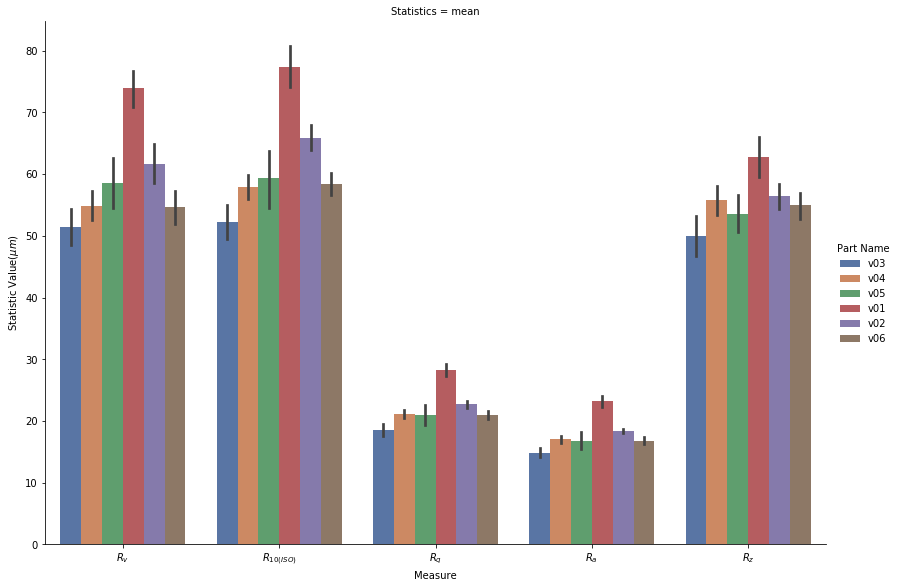

In [35]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Part Name', row='Statistics')
#savefig('global_measure_comparison_files_vs_files.svg')

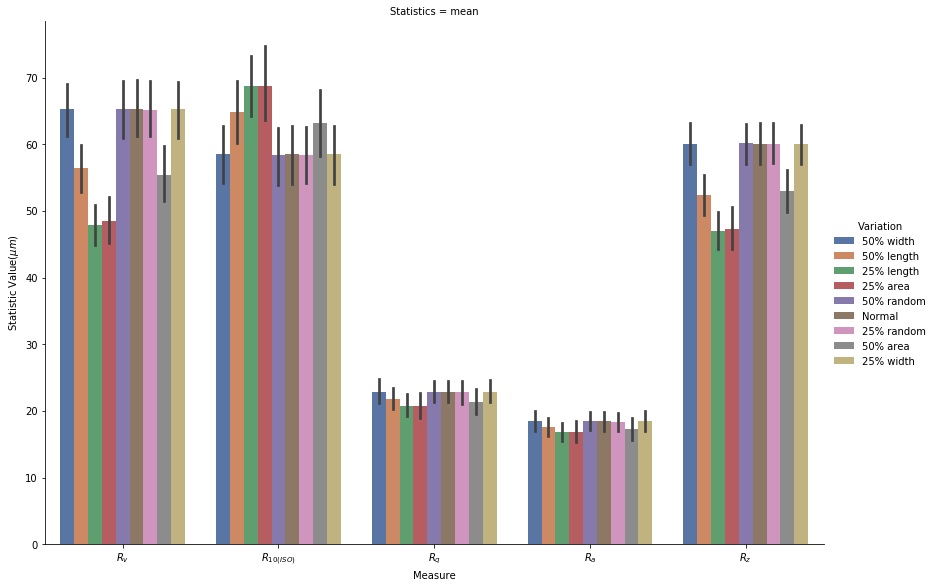

In [37]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Variation', row='Statistics')
savefig('global_measure_comparison_variation_vs_varation.svg')

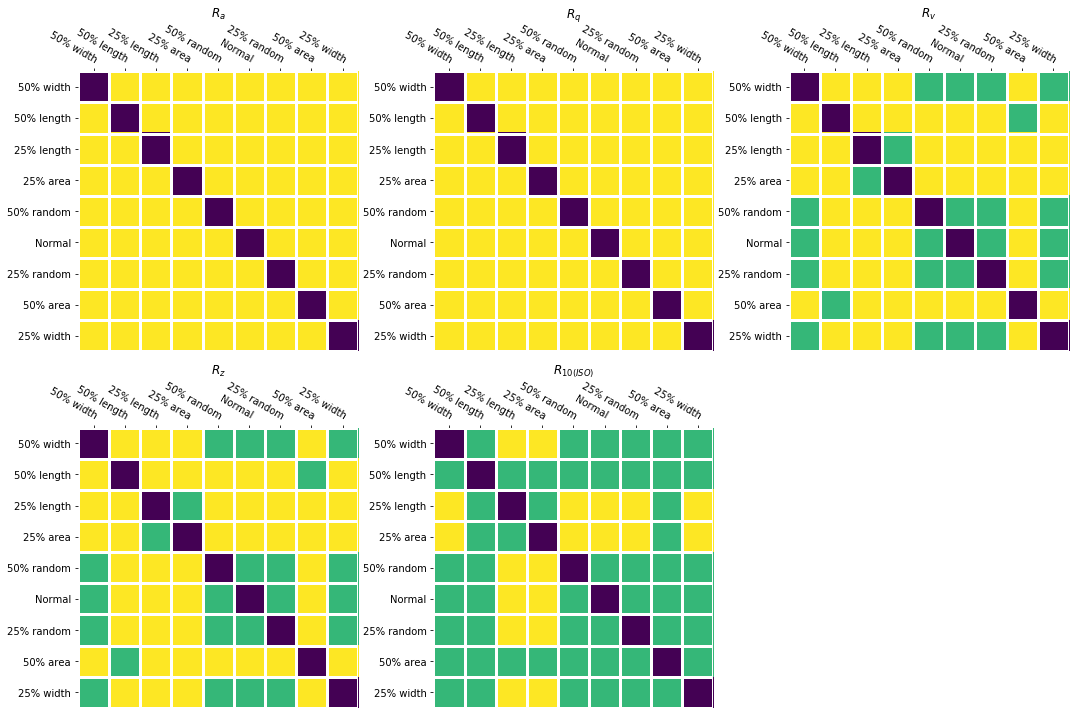

In [39]:
rcParams['figure.figsize'] = 15, 15
from scipy.stats import ttest_ind
ncols = 3
nrows = int(np.round(len(name_dict)/ncols+.99))
for index, (feature, feature_neat) in enumerate(name_dict.items(), 1):
    #ax = subplot2grid((nrows, ncols), (index//ncols, index%ncols))
    ax = subplot(nrows, ncols, index)
    d = data[(data['Statistics'] == 'mean')&(data['Measure']==name_dict[feature])]
    unique_variations = data['Variation'].unique()
    pvalues = -2*np.ones((len(unique_variations),)*2)
    for i, v1 in enumerate(unique_variations):
        d1 = d[(d['Variation'] == v1)][['Statistic Value($\mu m$)']]
        for j, v2 in enumerate(unique_variations):
            if i <= j:
                continue
            d2 = d[(d['Variation'] == v2)][['Statistic Value($\mu m$)']]
            pvalues[j, i] = pvalues[i,j]=(ttest_ind(d1, d2).pvalue[0] < .05)*1
    im, cbar = heatmap(pvalues, unique_variations, unique_variations, ax=ax, color_bar=False, 
                       plot_title=feature_neat)
tight_layout() # Or equivalently,  "plt.tight_layout()"
savefig('hypthesis_test_variation_vs_variation.svg')

In [25]:
#circle_stats = {name: mardas(feature[0]) for name, feature in zip(file_names, result)}
#circle_stats = {name: feature[0].circle_statistics for name, feature in zip(file_names, result)}
#circle_stats = {f_name:{k:feature.circle_statistics for k, feature in zip(images_mapper, read_pickle(f_name))} for f_name in file_names}
with ProcessingPool(len(file_names)) as t:
    circle_stats = dict(t.map(lambda f_name: (f_name,{k:feature.circle_statistics for k, feature in zip(images_mapper, read_pickle(f_name))}), file_names))

In [26]:
name_dict = {'rho':r"$\rho$", 'rho95': r"$\rho_{95}$"}
names = images_mapper.keys() - set('50% area rotate; 50% area tilt; 50% length tilt; 50% width tilt; 50% length rotate; 50% length tilt'.split('; '))
statistics = ['mean']
data = pd.DataFrame(
    [(file_name, name_dict[column], name, statistic, stat[name][column].describe()[statistic])
     for file_name, stat in circle_stats.items()
     for i,name in enumerate(names) 
     for column in stat[name].columns
     for statistic in statistics],
    columns=["File Name", 'Measure', 'Variation', 'Statistics', 'Statistic Value($\mu m$)'])

In [27]:
#data['File Name'] = data['File Name'].apply(lambda x: x.split('/')[-1].split('_')[0][1:]+'x')
data['File Name'] = data['File Name'].apply(lambda x: splitext(basename(x))[0])
data['Part Name'] = data['File Name'].str[:3]

In [28]:
#sns.set_palette("deep")
#ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='File Name', row='Statistics')
#savefig('local_measure_comparison_files_vs_files.svg')

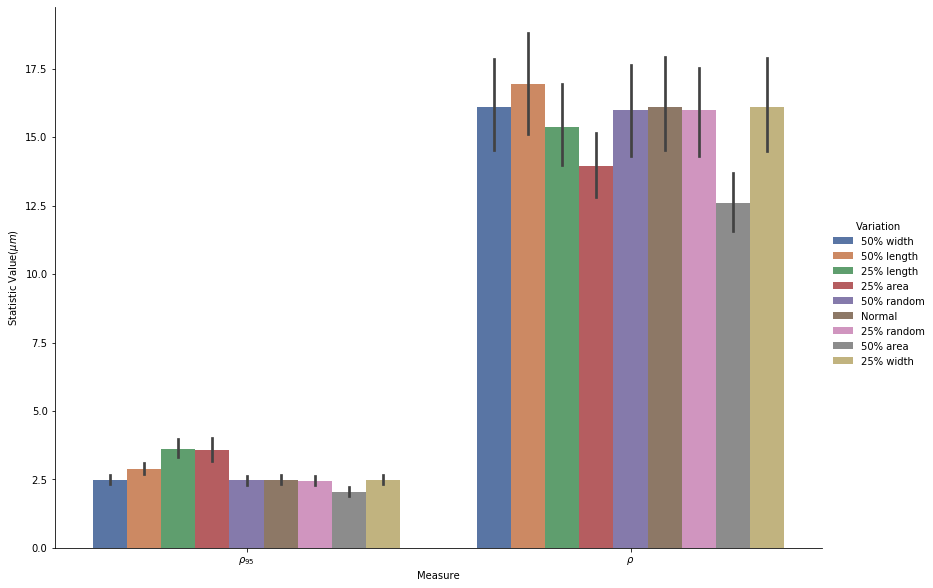

In [30]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Variation', 
                 #row='File Name',
                )
savefig('local_measure_comparison_variation_vs_variation.svg')

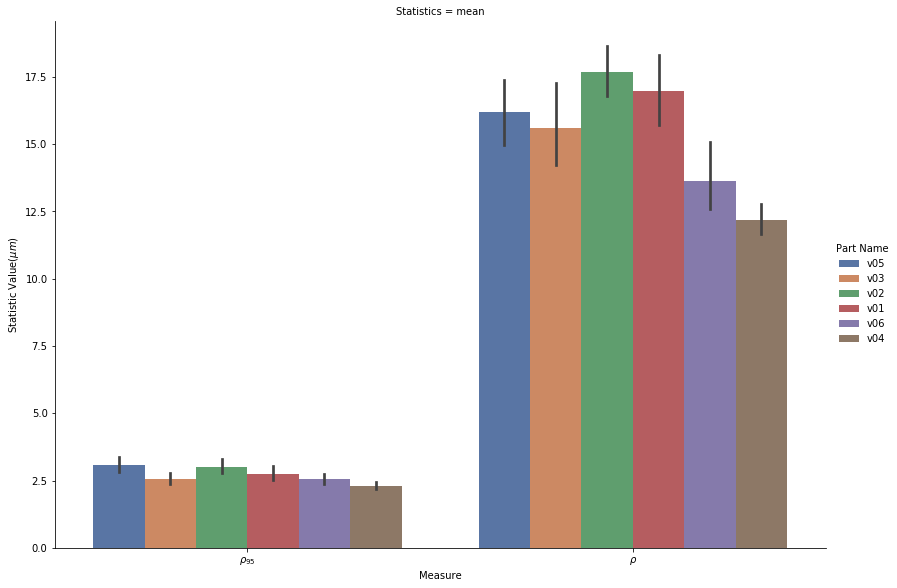

In [109]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Part Name', row='Statistics')
savefig('local_measure_comparison_parts_vs_parts.svg')

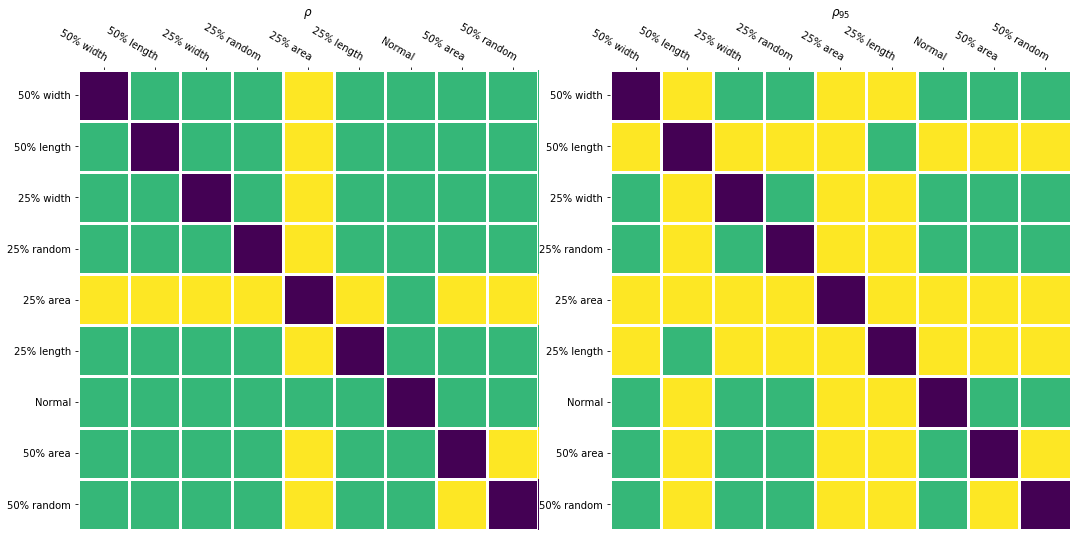

In [118]:
rcParams['figure.figsize'] = 15, 15
from scipy.stats import ttest_ind
ncols = 2
nrows = int(np.round(len(name_dict)/ncols+.99))
for index, (feature, feature_neat) in enumerate(name_dict.items(), 1):
    #ax = subplot2grid((nrows, ncols), (index//ncols, index%ncols))
    ax = subplot(nrows, ncols, index)
    d = data[(data['Statistics'] == 'mean')&(data['Measure']==name_dict[feature])]
    unique_variations = data['Variation'].unique()
    pvalues = -2*np.ones((len(unique_variations),)*2)
    for i, v1 in enumerate(sorted(unique_variations)):
        d1 = d[(d['Variation'] == v1)][['Statistic Value($\mu m$)']]
        for j, v2 in enumerate(unique_variations):
            if i <= j:
                continue
            d2 = d[(d['Variation'] == v2)][['Statistic Value($\mu m$)']]
            test_result = ttest_ind(d1, d2)
            pvalues[j, i] = pvalues[i,j]=(test_result.pvalue[0] < .05)*1
    im, cbar = heatmap(pvalues, unique_variations, unique_variations, ax=ax, color_bar=False, 
                       plot_title=feature_neat)
tight_layout() # Or equivalently,  "plt.tight_layout()"

In [117]:
sorted(unique_variations)

['25% area',
 '25% length',
 '25% random',
 '25% width',
 '50% area',
 '50% length',
 '50% random',
 '50% width',
 'Normal']

In [44]:
with open('dataset/v06_T2_L_3d.df', 'rb') as f:
    df = pickle.load(f)

In [47]:
df

,profile,beg,end,index,h,cx,cy,r,x_mean,x_std,y_mean,y_std
0,46,2203,2210,2206,-1.000000,2194.796611,22.109461,19.687603,0,1,0,1
1,54,2189,2208,2198,3.172577,2206.381818,19.605110,6.734842,0,1,0,1
2,62,1944,1971,1957,25.959323,1998.040732,38.777493,35.572210,0,1,0,1
3,63,1942,1971,1956,26.136857,1999.326468,42.321788,39.096017,0,1,0,1
4,64,2118,2163,2140,3.904924,2181.234452,23.172025,21.999485,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
133225,7240,2639,2648,2643,4.258624,2647.401260,7.056905,4.129604,0,1,0,1
133226,7241,384,399,391,4.690265,396.678440,9.366167,4.356325,0,1,0,1
133227,7241,1976,1987,1981,1.999238,1986.464006,19.626855,18.412730,0,1,0,1
133228,7241,2639,2648,2643,3.775918,2647.738149,6.651628,4.488892,0,1,0,1


In [48]:
with open('dataset/v06_T1_R_3d.features', 'rb') as f:
    image = pickle.load(f)

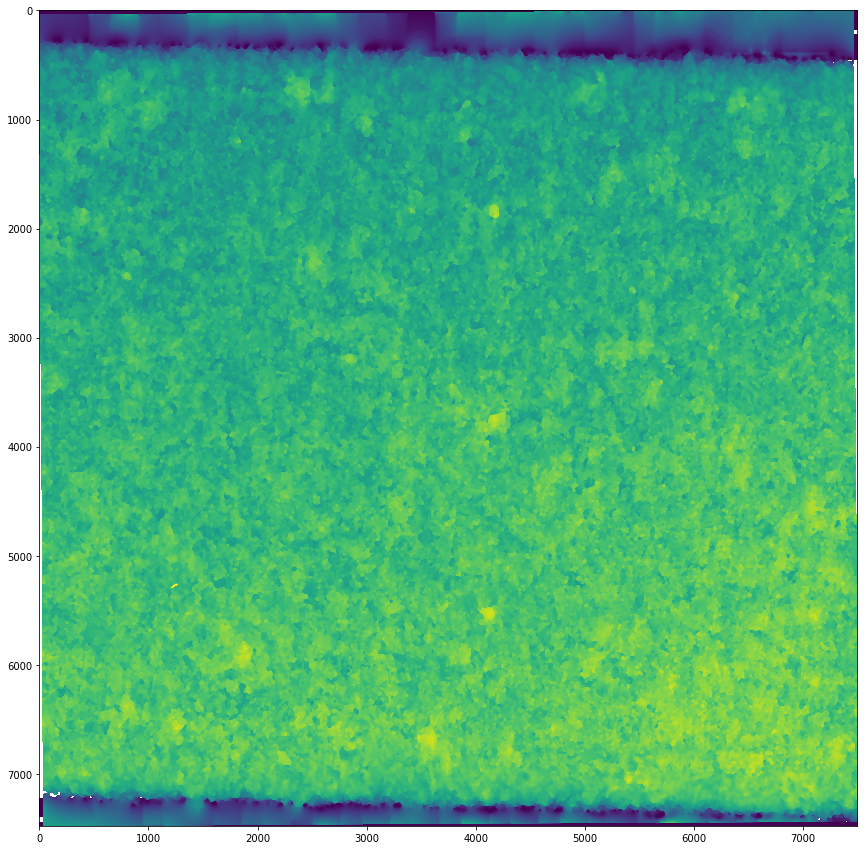

In [53]:
imshow(image[0].x)

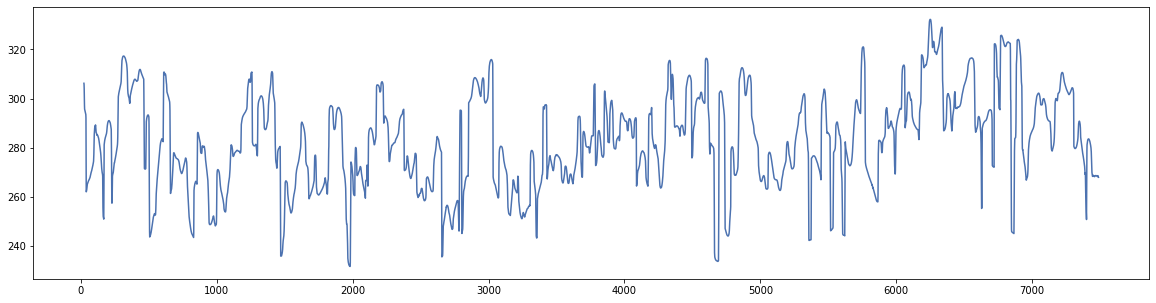

In [58]:
rcParams['figure.figsize'] = 20, 5
plot(image[0].x[5000])

In [19]:
from dask.distributed import LocalCluster, Client

In [20]:
#Cluster = LocalCluster(n_workers=10, threads_per_worker=2)

In [21]:
#client = Client(Cluster)

In [22]:
#client

In [183]:
def read_data(f_name):
    _ = joblib.load(f_name)
    print(f"finished {f_name}")
    _ = _[0].circle_statistics.copy()
    _['part'] = f_name
    return _

In [184]:
res = bag.from_sequence(files).map(read_data)

In [185]:
import joblib
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool
with dask.config.set(pool=Pool(10)):
    res = res.compute()

finished dataset/v01_T2_L_3d.features
finished dataset/v01_T1_R_3d.features
finished dataset/v04_T2_L_3d.features
finished dataset/v05_T2_L_3d.features
finished dataset/v05_T2_R_3d.features
finished dataset/v05_T1_R_3d.features
finished dataset/v03_T2_L_3d.features
finished dataset/v04_T1_L_3d.features
finished dataset/v06_T1_R_3d.features
finished dataset/v06_T2_L_3d.features
finished dataset/v02_T1_L_3d.features
finished dataset/v02_T2_R_3d.features
finished dataset/v03_T2_R_3d.features
finished dataset/v04_T2_R_3d.features
finished dataset/v02_T2_L_3d.features
finished dataset/v02_T1_R_3d.features
finished dataset/v05_T1_L_3d.features
finished dataset/v01_T2_R_3d.features
finished dataset/v03_T1_L_3d.features
finished dataset/v06_T1_L_3d.features
finished dataset/v04_T1_R_3d.features
finished dataset/v03_T1_R_3d.features
finished dataset/v01_T1_L_3d.features


In [186]:
old_local_stats = pd.concat(res)#.part.unique

In [187]:
_ = old_local_stats.part.map(lambda x: splitext(basename(x.lower()))[0]).str.split('_', expand=True).drop(3, axis=1)
_.columns = ['specimen', 'T', 'RL']
old_local_stats = pd.concat([old_local_stats, _], axis=1)#.drop('part', axis=1)

In [188]:
new_local_stats = joblib.load('/nfs_shares/bzr0014_home/additive_data/local_stats.df')

In [189]:
new_local_stats = new_local_stats.assign(part=new_local_stats.part.str.lower())
new_local_stats = new_local_stats.assign(ispolished=new_local_stats.part.map(lambda x: 'polished' in x))#.part.str.lower().str.split('_', expand=True)

In [190]:
info = new_local_stats.part.str.replace('polished_', '').str.split('_', expand=True).drop([3, 4], axis=1)

In [191]:
info.columns = ['specimen', 'T', 'RL']

In [192]:
info.RL = info.RL.str[0]

In [193]:
new_local_stats = pd.concat([info, new_local_stats], axis=1)#.drop('part', axis=1)

In [194]:
old_local_stats = old_local_stats.assign(ispolished=False).assign(part=old_local_stats.part.map(lambda x: splitext(basename(x))[0]))

In [198]:
old_local_stats

,rho95,rho,part,specimen,T,RL,ispolished
profile,,,,,,,
70,46.820795,58.058405,v04_T2_L_3d,v04,t2,l,False
71,47.420704,57.840504,v04_T2_L_3d,v04,t2,l,False
72,29.848770,49.236047,v04_T2_L_3d,v04,t2,l,False
73,35.969186,52.492730,v04_T2_L_3d,v04,t2,l,False
74,33.333277,51.682507,v04_T2_L_3d,v04,t2,l,False
...,...,...,...,...,...,...,...
7345,40.461124,372.728191,v01_T1_L_3d,v01,t1,l,False
7346,39.387976,530.156054,v01_T1_L_3d,v01,t1,l,False
7347,39.068106,548.005626,v01_T1_L_3d,v01,t1,l,False


In [200]:
set(old_local_stats.columns) == set(new_local_stats.columns)

True

In [201]:
both_old_and_new = pd.concat([old_local_stats, new_local_stats])

In [211]:
specimens = {'v01', 'v07'}
_ = both_old_and_new[both_old_and_new.specimen.isin(specimens)].dropna()

In [212]:
_.groupby(['specimen', 'T', 'RL', 'ispolished']).mean()

rho95        rho
specimen T  RL ispolished                     
v01      t1 l  False       2.399354  15.262919
               True        4.099787  25.064504
            r  False       1.904385  13.579967
               True        3.825746  22.591532
         t2 l  False       2.674705  24.304624
               True        8.646329  39.973657
            r  False       3.134909  18.453185
               True        7.370600  41.561845
v07      t1 l  False       3.070637  21.011283
               True        5.081439  39.350407
            r  False       2.669582  19.527865
               True        6.360200  38.129690
         t2 l  False       2.192622  17.640597
               True        3.973062  24.533403
            r  True        4.259990  23.591833

In [213]:
both_old_and_new = joblib.load('/nfs_shares/bzr0014_home/additive_data/global_stats_both_old_and_new.df')

In [214]:
_ = both_old_and_new[both_old_and_new.specimen.isin(specimens)].dropna()
_.groupby(['specimen', 'T', 'RL', 'ispolished']).mean()

rv    r10_iso         rq         ra  \
specimen T  RL ispolished                                               
v01      t1 l  False       77.409960  78.755269  30.847396  25.388906   
               True        25.794608  43.771917  17.378814  14.977591   
            r  False       84.601484  78.645728  31.311489  25.724963   
               True        26.087366  44.874568  18.028523  15.611363   
         t2 l  False       76.377932  63.500473  25.133881  20.621180   
               True        15.277144  28.096508  10.442146   8.681977   
            r  False       81.517077  69.500444  26.969284  22.032345   
               True        15.248543  28.421432  10.766014   9.014297   
v07      t1 l  False       62.011743  51.271023  20.387204  16.724518   
               True        20.769794  32.754820  12.915100  10.976629   
            r  False       64.106763  55.056344  21.847673  17.920178   
               True        24.593260  39.067954  14.963314  12.632881   
         t2 l  False       67.266412  57.115441  22.614073  18.379147   
               True        37.023981  50.811954  16.369342  13.285567   
            r  True        23.144521  35.832129  14.044761  11.955560   

                                  rz  
specimen T  RL ispolished             
v01      t1 l  False       75.651242  
               True        45.781556  
            r  False       77.463783  
               True        47.703738  
         t2 l  False       56.100486  
               True        32.349183  
            r  False       62.390334  
               True        32.534755  
v07      t1 l  False       44.400192  
               True        34.932430  
            r  False       50.976667  
               True        39.892640  
         t2 l  False       52.713467  
               True        42.904854  
            r  True        38.755735

In [226]:
x = np.random.rand(1000)
np.mean(x), np.median(x)

(0.48676877342380614, 0.470380054059626)

In [227]:
x[x > .75] = .75

In [228]:
np.mean(x), np.median(x)

(0.45652103192068344, 0.470380054059626)

In [297]:
len(glob.glob("/nfs_shares/bzr0014_home/additive_data/*.pd"))

75

In [289]:
for file in glob.glob("/nfs_shares/bzr0014_home/additive_data/*3d.df"):
    if file.endswith('ed.np'): continue
    os.rename(file, splitext(file)[0]+'.pd')

In [257]:
import os

In [298]:
os.mkdir("/nfs_shares/bzr0014_home/additive_data/experiment_01")

In [ ]:
os.mkdir('')

In [71]:
_ = pd.DataFrame([(x.meta.name, np.mean(x.value.kernel_sizes)) for x in all_stats], columns=['file', 'kernel'])

In [73]:
_ = clean_shit(_, 'file')

In [74]:
_.groupby(['specimen', 'ispolished']).mean()

kernel
specimen ispolished        
v01      False         30.0
         True          30.0
v07      False         30.0
         True          30.0

In [75]:
_2

NameError: name '_2' is not defined

In [27]:
import joblib
_ = joblib.load(files[0])

In [38]:
_1 = _[20]
_1[_1>0]

array([78.649, 78.67 , 78.692, ..., 98.674, 98.676, 98.678], dtype=float32)

In [11]:
global_stats = joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_02/global_stats.df')
local_stats = joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_02/local_stats.df')

NameError: name 'joblib' is not defined

In [170]:
_ = global_stats[global_stats.specimen.isin({'v01', 'v07'})]

In [169]:
_.groupby(['specimen', 'ispolished']).mean()

ra         rq    r10_iso         rv         rz
specimen ispolished                                                       
v01      False       22.985054  28.173986  49.691386  79.473573  98.649206
         True        11.938669  14.081548  27.792400  20.200272  48.388009
v07      False       17.173527  21.109497  36.656125  63.756822  71.326852
         True        12.018504  14.413348  29.196035  26.346063  50.715292

In [166]:
_ = local_stats[local_stats.specimen.isin({'v01', 'v07'})]

In [167]:
_.groupby(['specimen', 'ispolished']).mean()

rho95        rho
specimen ispolished                     
v01      False       4.348549  19.357097
         True        7.533108  37.429910
v07      False       4.928075  21.399006
         True        7.707951  39.516174

In [135]:
[x for x in files if 'v07' in x.lower() and 't1' in x.lower()]

['/nfs_shares/bzr0014_home/additive_data/Polished_V07_T1_Left(Bottom)_500X_3D.pd',
 '/nfs_shares/bzr0014_home/additive_data/Polished_V07_T1_Right(Top)_500X_3D.pd',
 '/nfs_shares/bzr0014_home/additive_data/V07_T1_Left(Bottom)_500X_3D.pd',
 '/nfs_shares/bzr0014_home/additive_data/V07_T1_Right(Top)_500X_3D.pd']

In [117]:
import joblib
polished_ =   joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_03/Polished_V07_T1_Left(Bottom)_500X_3D.info')
unpolished_ = joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_03/V07_T1_Left(Bottom)_500X_3D.info')

In [119]:
n = 300
polished = polished_['value'].x[300:-300, 300:-300]
unpolished = unpolished_['value'].x[300:-300, 300:-300]
#polished = polished[polished > polished.mean()-3*polished.std()]
#unpolished = unpolished[unpolished > unpolished.mean()-3*unpolished.std()]

In [120]:
_ = np.sort(polished[np.where((polished > polished.mean()-3*polished.std()) & 
                          (polished==cv2.erode(polished, kernel=np.ones((20, 20)))))])

In [121]:
_[_>124.8][:20]

masked_array(data=[124.80925750732422, 124.82238006591797,
                   124.82424926757812, 124.83294677734375,
                   124.83519744873047, 124.84297180175781,
                   124.84514617919922, 124.85478973388672,
                   124.85530090332031, 124.86444091796875,
                   124.87154388427734, 124.87388610839844,
                   124.87870788574219, 124.88931274414062,
                   124.89599609375, 124.91913604736328,
                   124.95246124267578, 124.95439910888672,
                   124.96536254882812, 124.9675064086914],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [122]:
np.sort(unpolished[np.where((unpolished > unpolished.mean()-3*unpolished.std()) & 
                          (unpolished==cv2.erode(unpolished, kernel=np.ones((20, 20)))))])[:10]

masked_array(data=[128.95309448242188, 129.85000610351562,
                   129.9178009033203, 130.54124450683594,
                   131.65313720703125, 132.39132690429688,
                   132.51832580566406, 132.53921508789062,
                   132.6910858154297, 132.6986541748047],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20,
            dtype=float32)

In [123]:
polished[np.where((polished > polished.mean()-3*polished.std()))].mean()

138.8310833505119

In [124]:
unpolished[np.where((unpolished > unpolished.mean()-3*unpolished.std()))].mean()

188.54001247665153

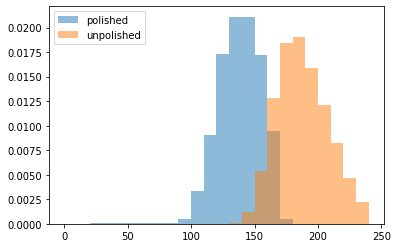

In [125]:
import matplotlib.pyplot as plt
_1 = np.round(polished, decimals=1)
_2 = np.round(unpolished, decimals=1)
_1 = plt.hist(_1.reshape(-1), bins=np.arange(0, 250, 10), density=True, alpha=.5, label='polished')
_2 = plt.hist(_2.reshape(-1), bins=np.arange(0, 250, 10), density=True, alpha=.5, label='unpolished')
plt.legend()

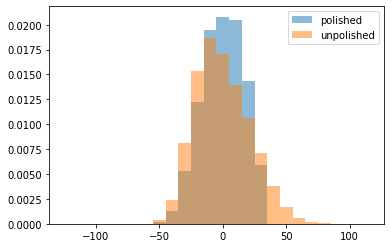

In [191]:
import matplotlib.pyplot as plt
_1 = np.round(polished-polished.mean(), decimals=1)
_2 = np.round(unpolished-unpolished.mean(), decimals=1)
_1 = plt.hist(_1.reshape(-1), bins=np.arange(-125, 125, 10), density=True, alpha=.5, label='polished')
_2 = plt.hist(_2.reshape(-1), bins=np.arange(-125, 125, 10), density=True, alpha=.5, label='unpolished')
plt.legend()

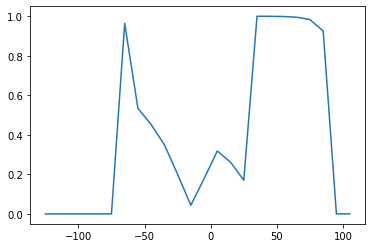

In [192]:
plt.plot(_1[1][:-1], np.abs(_1[0] - _2[0])/(np.maximum(_1[0], _2[0])+.000001))

In [181]:
polished.min()

1.6565423

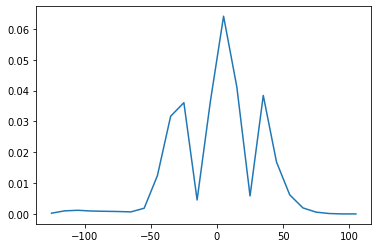

In [176]:
plt.plot(_1[1][:-1], np.abs(_1[0] - _2[0])*10)

In [123]:
np.percentile(unpolished, 9)

114.09430625915527

In [142]:
def _1(p):
    return np.percentile(unpolished, p)
def _2(p):
    return np.percentile(polished, p)
with Pool(20) as p:
    unpolished_percentiles = p.map(_1, list(range(100)))
    polished_percentiles = p.map(_2, list(range(100)))

In [154]:
np.percentile(polished, np.argmin(np.abs(_[1:, 0] - _[1:, 1])))

52.112906799316406

In [193]:
polished

array([91.94856 , 91.971146, 91.99349 , ..., 86.87725 , 86.03119 ,
       85.05079 ], dtype=float32)

In [15]:
from scipy import signal

In [17]:
import scipy.stats as st
def gkern2d(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.max()

In [18]:
def gkern1d(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    return kern1d/kern1d.max()

In [31]:
n = 300
polished = polished_.value.x#[300:-300, 300:-300]
unpolished = unpolished_.value.x#[300:-300, 300:-300]

In [32]:
from scipy.ndimage.filters import convolve

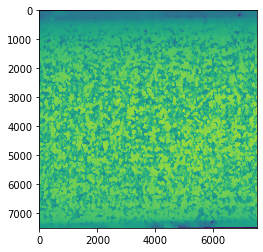

In [33]:
import matplotlib.pyplot as plt
M = 31
_ = gkern2d(M, 5)
k3 = _ / _.sum()
polished = convolve(polished, k3)
plt.imshow(polished)

In [35]:
polished[1000, 1000]

103.7443

In [37]:
M = 31
m = M//2
k1 = np.ones((M, M))
k2 = np.zeros((M, M), dtype='uint8')
k2[m] = 1
k2[:, m] = 1
#_ = gkern(M, 5)
#k3 = _ / _.max()
_ = np.where((polished > polished.mean()-3*polished.std()) & 
                          (polished==cv2.erode(polished, kernel=k1)))

In [38]:
w, h = polished.shape
_ = np.array([[x, y] for x, y in zip(*_) if x > 300 and x < w-300 and y > 300 and y < h-300])
_ = (_[:,0].reshape(-1), _[:,1].reshape(-1))

In [39]:
n = 10
args = np.argsort(polished[_])[:n]
smallest_n = (np.array([_[0][i] for i in args]), np.array([_[1][i] for i in args]))

In [41]:
smallest_n

(array([ 745, 1123,  778, 1282, 1151,  755, 1057, 1983, 1080,  348]),
 array([3680, 4662, 6780, 1612,  777, 6829,  320, 3446, 6749, 5774]))

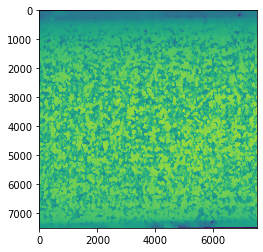

In [42]:
plt.imshow(polished)

In [43]:
filtered_k3[1000, 2000],  polished[1000, 2000]

NameError: name 'filtered_k3' is not defined

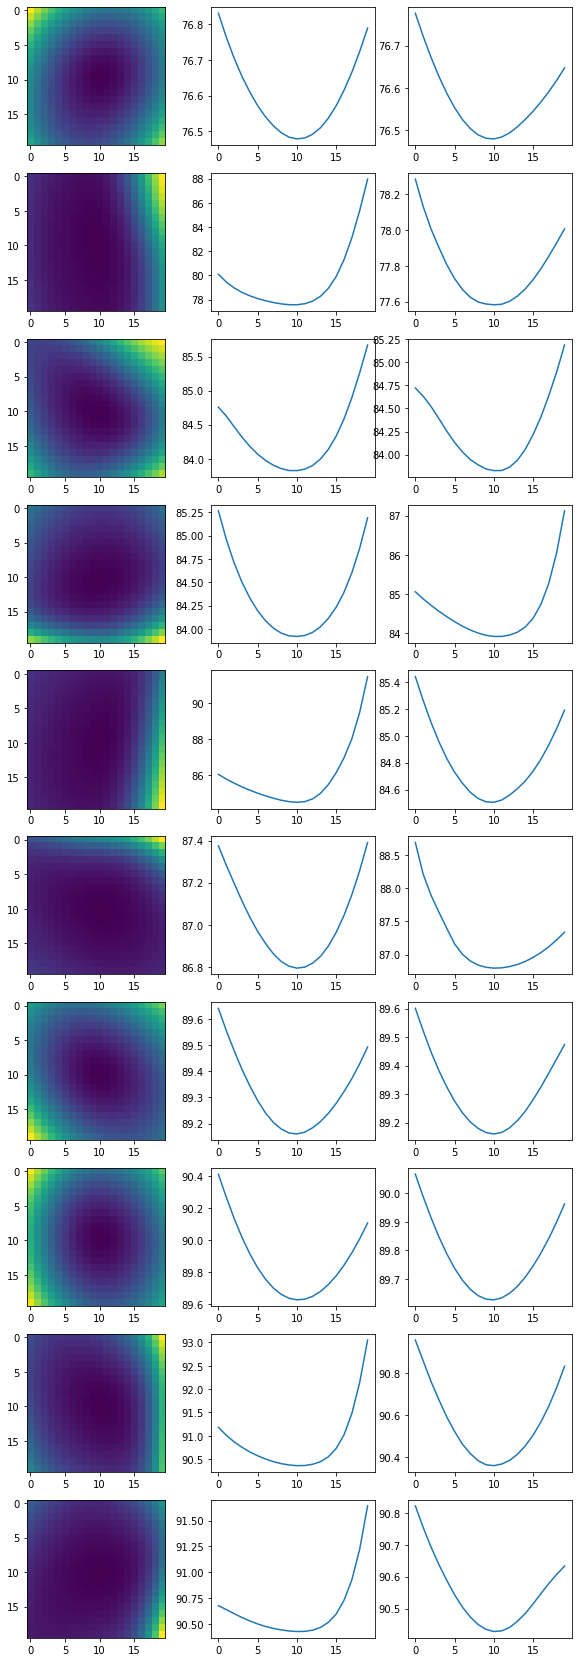

In [44]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n, 3, figsize=(10, 30))
axes=axes.reshape(-1)
for c, (i, j) in enumerate(zip(*smallest_n)):
    x = polished[i-10:i+10, j-10:j+10]
    axes[c*3].imshow(x)
    axes[c*3+1].plot(x.min(axis=0))
    axes[c*3+2].plot(x.min(axis=1))
for i in range(3*(c+1), len(axes)):
    axes[i].axis('off')

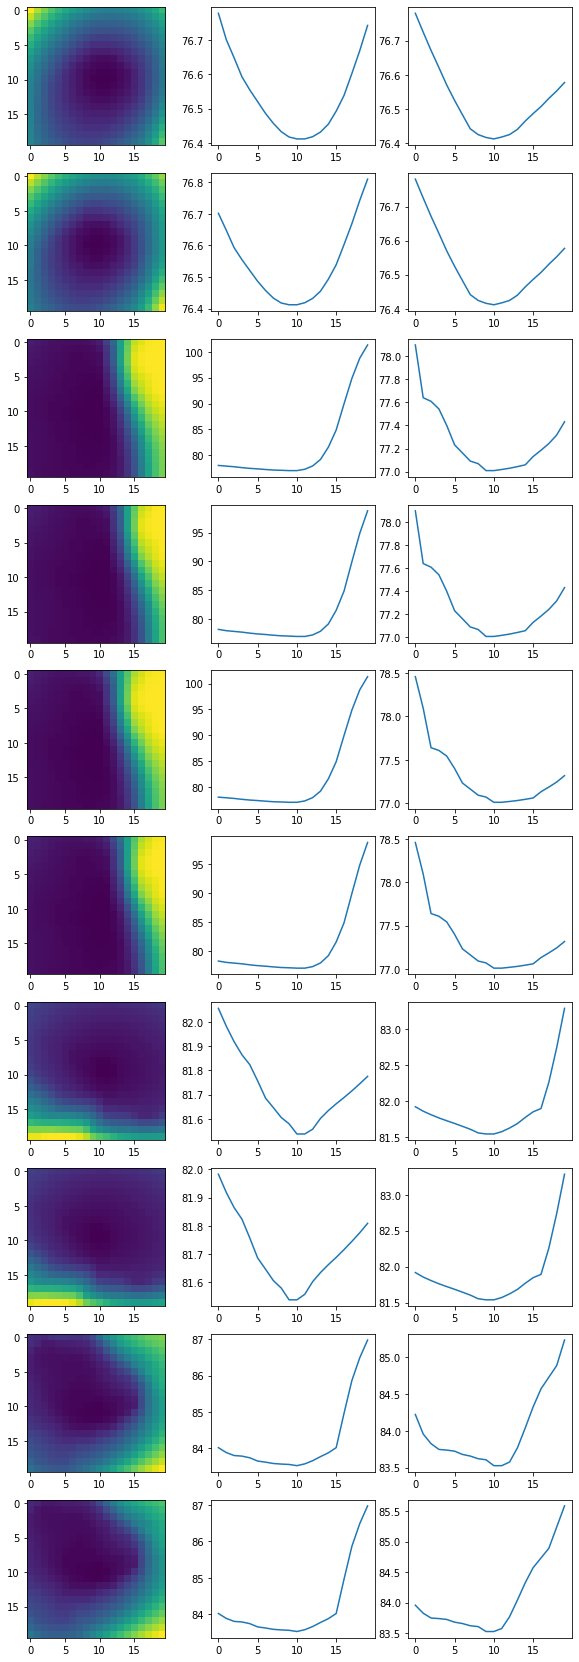

In [203]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n, 3, figsize=(10, 30))
axes=axes.reshape(-1)
for c, (i, j) in enumerate(zip(*smallest_n)):
    x = polished[i-10:i+10, j-10:j+10]
    axes[c*3].imshow(x)
    axes[c*3+1].plot(x.min(axis=0))
    axes[c*3+2].plot(x.min(axis=1))
for i in range(3*(c+1), len(axes)):
    axes[i].axis('off')

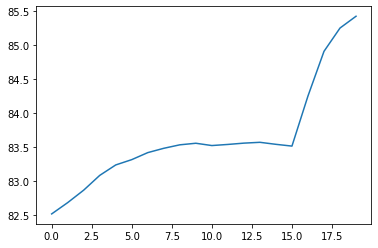

In [191]:
plt.plot(x.min(axis=0)*gkern1d(len(x), .2))

In [188]:
gkern1d(len(x), .1)

array([0.99551015, 0.9964065 , 0.99720394, 0.99790222, 0.99850114,
       0.99900051, 0.99940018, 0.99970005, 0.99990001, 1.        ,
       1.        , 0.99990001, 0.99970005, 0.99940018, 0.99900051,
       0.99850114, 0.99790222, 0.99720394, 0.9964065 , 0.99551015])

In [178]:
_ = gkern1d(5, 2)
_

array([0.29699686, 0.73834132, 1.        , 0.73834132, 0.29699686])

In [143]:
t = pd.DataFrame([x.split() for x in """surface_condition  specimen_id  frequency  strain_amplitude  fatigue_life  reversal
as-built  v02  5  0.004  45859  91718   
as-built  v10  5  0.004  49177  98354   
as-built  v04  7.5  0.003  91222  182444   
as-built  v08  7.5  0.003  136464  272928   
as-built  v12  8  0.0025  192404  384808   
as-built  v14  8  0.0025  320856  641712   
as-built  v06  10  0.002  5000000  10000000   
half-polished  v07  5  0.004  50916  101832   
half-polished  v09  5  0.004  60992  121984   
half-polished  v05  7.5  0.003  153540  307080   
half-polished  v03  7.5  0.003  163123  326246   
half-polished  v13  8  0.0025  287061  574122   
half-polished  v11  8  0.0025  291206  582412   
half-polished  v01  10  0.002  5000000  10000000   
quarter-polished  v15  7.5  0.003  132668  265336 
quarter-polished  v17  8  0.0025  395801  791602""".split('\n')])
t.columns = t.loc[0]
t = t.drop(0)

In [145]:
for col in t.columns[2:]:
    t[col] = pd.to_numeric(t[col])

In [207]:
t#.groupby('frequency').strain_amplitude.unique()

,surface_condition,specimen_id,frequency,strain_amplitude,fatigue_life,reversal
1,as-built,v02,5.0,0.0040,45859,91718
2,as-built,v10,5.0,0.0040,49177,98354
3,as-built,v04,7.5,0.0030,91222,182444
4,as-built,v08,7.5,0.0030,136464,272928
5,as-built,v12,8.0,0.0025,192404,384808
6,as-built,v14,8.0,0.0025,320856,641712
7,as-built,v06,10.0,0.0020,5000000,10000000
8,half-polished,v07,5.0,0.0040,50916,101832
9,half-polished,v09,5.0,0.0040,60992,121984
10,half-polished,v05,7.5,0.0030,153540,307080


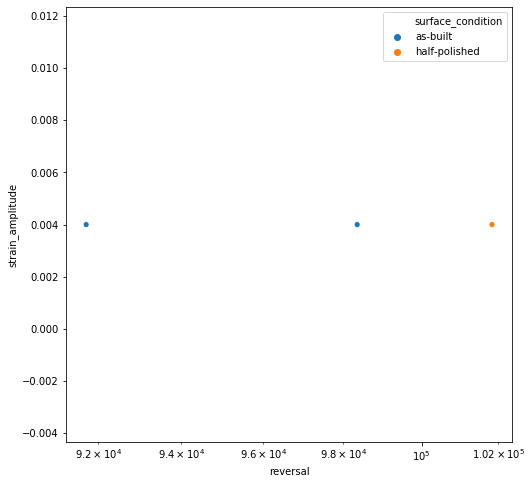

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(data=t[t.reversal<1.2e5]
                , x='reversal', y='strain_amplitude', hue='surface_condition', ax=ax)
ax.set_xscale('log')

In [219]:
t[(t.reversal<1.2e5)&(t.reversal>9.3e4)]

,surface_condition,specimen_id,frequency,strain_amplitude,fatigue_life,reversal
2,as-built,v10,5.0,0.004,49177,98354
8,half-polished,v07,5.0,0.004,50916,101832


In [209]:
t[(t.strain_amplitude==.003)]
_ = global_stats[(_1.isin({'v10'})) | ((_1=='v07') & (_2==True))]

,surface_condition,specimen_id,frequency,strain_amplitude,fatigue_life,reversal
3,as-built,v04,7.5,0.003,91222,182444
4,as-built,v08,7.5,0.003,136464,272928
10,half-polished,v05,7.5,0.003,153540,307080
11,half-polished,v03,7.5,0.003,163123,326246
15,quarter-polished,v15,7.5,0.003,132668,265336


In [210]:
_1 = global_stats.specimen
_2 = global_stats.ispolished
_ = global_stats[(_1.isin({'v10'})) | ((_1=='v07') & (_2==True))]
_
_.groupby(['specimen']).mean()

,ra,rq,r10_iso,rv,rz,ispolished
specimen,,,,,,
v07,12.018504,14.413348,29.196035,26.346063,50.715292,True
v10,22.493474,27.692944,49.290443,74.621507,95.330270,False


In [213]:
_1 = local_stats.specimen
_2 = local_stats.ispolished
_ = local_stats[(_1.isin({'v10'})) | ((_1=='v07') & (_2==True))]
_
_.groupby(['specimen'])[['rho']].mean()

,rho
specimen,
v07,39.516174
v10,32.681169


In [194]:
101832/91718, 101832/98354

(1.1102727926906386, 1.0353620594993596)

In [196]:
39.516174/26.441493, 39.516174/32.681169

(1.4944758981650543, 1.2091419985619243)

In [185]:
local_stats.groupby(['specimen', 'ispolished']).mean()

rho95        rho
specimen ispolished                     
v01      False       4.348549  19.357097
         True        7.533108  37.429910
v02      False       5.648347  26.441493
v03      False       4.885138  21.036272
v04      False       4.445790  18.407507
v05      False       4.818134  21.822909
v06      False       4.908394  20.432814
v07      False       4.928075  21.399006
         True        7.707951  39.516174
v08      False       4.891646  23.687354
v09      False       4.481839  21.615817
v10      False       4.915980  32.681169
v11      False       4.244362  18.306309
v12      False       5.591647  23.146370

In [9]:
import os
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

In [17]:
def dfe(p):
    d = os.path.dirname(p)+"/"
    b = os.path.basename(p)
    return (d, *os.path.splitext(b))

In [18]:
dfe('/nfs_shares/bzr0014_home/additive_data/experiment_01/global_stats.df')

('/nfs_shares/bzr0014_home/additive_data/experiment_01/',
 'global_stats',
 '.df')

In [22]:
_1 = {dfe(p)[1] for p in glob.glob('/nfs_shares/bzr0014_home/additive_data/*pd')}

In [23]:
_2 = {dfe(p)[1] for p in glob.glob('/nfs_shares/bzr0014_home/additive_data/new_files/*csv')}

In [28]:
len(_2 | _1)

126

In [31]:
len(_2)

51

In [17]:
import joblib
_ = joblib.load('/nfs_shares/bzr0014_home/additive_data/experiment_03/Polished_V07_T1_Left(Bottom)_500X_3D.info')

In [22]:
_

{'name': '/nfs_shares/bzr0014_home/additive_data/Polished_V07_T1_Left(Bottom)_500X_3D.pd',
 'variation': 'Normal',
 'value': <__main__.Features at 0x74a2bbd471d0>}